<a href="https://colab.research.google.com/github/juliabarsow/Facial-Expression-Recognition-CNN/blob/hyperparameter_optimization/CNN_face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install -U transformers
## Local Inference on GPU

In [2]:
# Loading necessaary libraries
import os
import tensorflow as tf
from tensorflow import keras
from transformers import AutoImageProcessor, AutoModelForImageClassification
import pandas as pd
import numpy as np
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
import datetime
import shutil
import matplotlib.pyplot as plt
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, RandomFlip, RandomRotation, RandomZoom, RandomTranslation
from sklearn.metrics import recall_score

In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [5]:
# Clear any logs from previous runs
!rm -rf ./logs/

⚠️ If the generated code snippets do not work, please open an issue on either the [model repo](https://huggingface.co/google/efficientnet-b3)
			and/or on [huggingface.js](https://github.com/huggingface/huggingface.js/blob/main/packages/tasks/src/model-libraries-snippets.ts) 🙏

Model page: https://huggingface.co/google/efficientnet-b3

In [6]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("image-classification", model="google/efficientnet-b3")
pipe("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/hub/parrots.png")

processor = AutoImageProcessor.from_pretrained("google/efficientnet-b3")
model = AutoModelForImageClassification.from_pretrained("google/efficientnet-b3")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/49.5M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/495 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


model.safetensors:   0%|          | 0.00/49.4M [00:00<?, ?B/s]

In [7]:
import kagglehub

# Download latest version of dataset
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fer2013' dataset.
Path to dataset files: /kaggle/input/fer2013


In [8]:
import os
files_in_dir = os.listdir(path)

print("Files in the directory:")
for file in files_in_dir:
    print(file)

Files in the directory:
test
train


We can see that in the kaggle directory we have test and train values

**1. Define the necessary parameters for the EfficientNet B3 model and the dataset loader.**

In [9]:
# Model Input Constants
IMG_SIZE = 300
BATCH_SIZE = 32 # @param {type: "slider", min:10, max:100}
NUM_CLASSES = 7

# Dataset Paths
BASE_PATH = path
train_dir = os.path.join(BASE_PATH, 'train')
test_dir = os.path.join(BASE_PATH, 'test')

# Sanity Check: Ensure the directories exist
if not os.path.isdir(train_dir) or not os.path.isdir(test_dir):
    print("Error: 'train' or 'test' directories not found in the specified path.")
    print(f"Checked paths: {train_dir}, {test_dir}")

**2. Load and preprocess data**

In [10]:
# Create the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical', # Converts labels to one-hot encoding (7 classes)
    image_size=(IMG_SIZE, IMG_SIZE),
    interpolation='bicubic',  # Use better interpolation for upscaling
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    color_mode='rgb'          # EfficientNet B3 expects 3 channels
)

# Create the validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_SIZE, IMG_SIZE),
    interpolation='bicubic',
    batch_size=BATCH_SIZE,
    shuffle=False, # No need to shuffle validation data
    color_mode='rgb'
)

print(f"Found {len(train_ds.class_names)} classes: {train_ds.class_names}")

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.
Found 7 classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


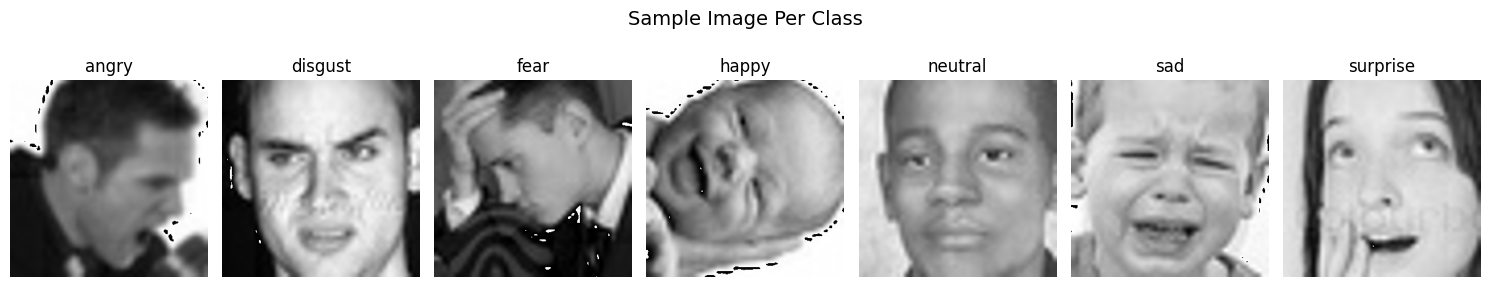

In [11]:
# Define the function to plot samples
def plot_samples_per_class(dataset, class_names):
    """Plots one sample image for each class in the dataset."""

    found_images = {}

    # We take a small sample to find all 7 classes without iterating over the entire dataset
    for images, labels in dataset.unbatch().take(100):

        # Convert one-hot label to class index
        class_index = tf.argmax(labels).numpy()

        # If we haven't found this class yet, store the image
        if class_index not in found_images:
            # We assume images are already in the [0, 255] range for display
            found_images[class_index] = images.numpy().astype("uint8")

        # Stop once all classes are found
        if len(found_images) == len(class_names):
            break

    # Plotting
    num_found = len(found_images)
    if num_found == 0:
        print("Error: No images found for plotting.")
        return

    plt.figure(figsize=(15, 3))

    sorted_indices = sorted(found_images.keys())

    if num_found < len(class_names):
        print(f"Warning: Only found {num_found}/{len(class_names)} classes.")

    for i, class_index in enumerate(sorted_indices):
        plt.subplot(1, num_found, i + 1)
        plt.imshow(found_images[class_index])
        plt.title(class_names[class_index])
        plt.axis("off")

    plt.suptitle("Sample Image Per Class", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig('sample_data_per_class.png')
    plt.show() # Display the plot

plot_samples_per_class(train_ds, train_ds.class_names)

In [ ]:
# Data Augmentation Layers
def get_augment_layers(HPARAMS):
    return tf.keras.Sequential(
        [
            RandomFlip("horizontal"),
            RandomRotation(HPARAMS['rotation_factor']),
            RandomZoom(height_factor=HPARAMS['zoom_factor'], width_factor=HPARAMS['zoom_factor']),
            RandomTranslation(height_factor=HPARAMS['translation_factor'], width_factor=HPARAMS['translation_factor'], fill_mode='nearest'),
        ],
        name="data_augmentation",
    )

**3. Setup and Project Infrastructure for training**

In [ ]:
# Define Run Configuration and Filepaths
RUN_NAME = "EfficientNetB3_FER2013_SanityCheck"
BASE_LOG_DIR = os.path.join("logs", RUN_NAME)
CHECKPOINT_DIR = os.path.join("checkpoints", RUN_NAME)

# Create/clear log and checkpoint directories for a clean run
if os.path.exists(BASE_LOG_DIR):
    shutil.rmtree(BASE_LOG_DIR)
os.makedirs(BASE_LOG_DIR, exist_ok=True) # Ensure BASE_LOG_DIR exists
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

HP_LEARNING_RATE_PHASE_1 = hp.HParam('learning_rate_phase_1', hp.RealInterval(1e-4, 1e-2))
HP_DROPOUT_RATE = hp.HParam('dropout_rate', hp.Discrete([0.2, 0.3, 0.4]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['Adam', 'RMSprop']))

# Define the Metric to Track
METRIC_MACRO_RECALL = 'macro_recall'

# Define Callbacks
# TensorBoard for persistent logging & plotting curves
tensorboard_callback = TensorBoard(
    log_dir=BASE_LOG_DIR,
    histogram_freq=1, # Log histograms for weights/biases
    write_graph=True,
    profile_batch=0, # Disable profiling for faster training
    update_freq='epoch'
)

# ModelCheckpoint for saving best model weights
checkpoint_filepath = os.path.join(
    CHECKPOINT_DIR,
    'weights_best_val_accuracy.weights.h5' # HDF5 format
)
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True, # Save only weights to reduce file size
    verbose=1
)

# EarlyStopping
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=3, # Wait 3 epochs for improvement
    restore_best_weights=True,
    verbose=1
)

# Group all callbacks
callbacks_list = [
    tensorboard_callback,
    model_checkpoint_callback,
    early_stopping_callback
]

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_LEARNING_RATE_PHASE_1, HP_DROPOUT_RATE, HP_OPTIMIZER],
        metrics=[hp.Metric(METRIC_MACRO_RECALL, display_name='Macro Recall')],
    )

# Define default Hyperparameters for logging
HPARAMS_DEFAULTS = {
    'learning_rate_phase_1': 1e-3,
    'learning_rate_phase_2': 1e-5,
    'epochs_phase_1': 5, # Low epochs for sanity check
    'epochs_phase_2': 10,
    'dropout_rate': 0.3,
    'optimizer': 'Adam',
    'base_model': 'EfficientNetB3',
    'input_size': 300,
    'rotation_factor': 0.1,
    'zoom_factor': 0.1,
    'translation_factor': 0.1
}

# Write HParams to a file for persistent logging (outside of TensorBoard HParams plugin)
with open(os.path.join(BASE_LOG_DIR, "hparams_default_config.txt"), "w") as f:
    for key, value in HPARAMS.items():
        f.write(f"{key}: {value}\n")

print(f"Logging setup complete. Logs directory: {BASE_LOG_DIR}")

**4. Model Definition and Finetuning**

In [ ]:
def build_efficientnet_model(input_shape, num_classes):
    # Load the pre-trained EfficientNetB3 without the top classification layer
    base_model = EfficientNetB3(
        weights='imagenet',
        include_top=False,  # this means we're using our own classification
        # drop_connect_rate = 0.4, # controls dropout rate for stochastic depth
        input_shape=input_shape
    )
    # Freeze the base model for initial training
    base_model.trainable = False

    # Define the Augmentation Layers
    augmentation_block = get_augment_layers(HPARAMS)

    # Construct the Sequential Model
    model = Sequential([
        # The input shape is automatically inferred from the first layer, but for clarity, the augmentation block handles the input layer implicitly.

        # Data Augmentation Block (New first layer)
        augmentation_block,

        # EfficientNet's built-in preprocessing (Scaling, 0-1 or -1 to 1 range)
        tf.keras.layers.Lambda(preprocess_input),

        # The pre-trained Base Model (Frozen)
        base_model,

        # Custom Classification Head
        GlobalAveragePooling2D(),
        Dropout(HPARAMS['dropout_rate']),
        Dense(256, activation='relu'),
        Dropout(HPARAMS['dropout_rate']),
        Dense(num_classes, activation='softmax', name='predictions') # Final output layer for 7 classes
    ])

    return model

# Build and Compile the Model
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
model = build_efficientnet_model(INPUT_SHAPE, NUM_CLASSES)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['recall']
)

model.summary()

We currently have no trainable params because we use pretrained base model up until now: base_model.trainable = False

**5. Sanity Check Training (Overfit to a Single Batch)**

In [ ]:
def build_efficientnet_functional(input_shape, num_classes, hparams_config):
    base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    inputs = Input(shape=input_shape)
    x = tf.keras.layers.Lambda(preprocess_input)(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(hparams_config['dropout_rate'])(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(hparams_config['dropout_rate'])(x)
    outputs = Dense(num_classes, activation='softmax', name='predictions')(x)
    model = Model(inputs, outputs)
    return model

In [ ]:
# Grab one batch for the sanity check
SANITY_BATCH_SIZE = HPARAMS['input_size']
for x_batch, y_batch in train_ds.take(1):
    X_sanity = x_batch
    y_sanity = y_batch
    break

# Create a tiny validation set for sanity check
for x_val_batch, y_val_batch in val_ds.take(1):
    X_val_sanity = x_val_batch
    y_val_sanity = y_val_batch
    break

# Build the model
INPUT_SHAPE = (HPARAMS['input_size'], HPARAMS['input_size'], 3)
NUM_CLASSES = 7
model = build_efficientnet_functional(INPUT_SHAPE, NUM_CLASSES)

# Compile and Train
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=HPARAMS['learning_rate_phase_1']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n--- Starting Sanity Check Training (Phase 0: Overfit to one batch) ---")

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


history_sanity = model.fit(
    X_sanity,
    y_sanity,
    batch_size=SANITY_BATCH_SIZE, # Train on this one batch repeatedly
    epochs=10, # More epochs to ensure it can overfit
    validation_data=(X_val_sanity, y_val_sanity),
    verbose=2,
    callbacks=[tensorboard_callback, model_checkpoint_callback] # Log this run
)

print(f"\nSanity Check complete. Check {BASE_LOG_DIR} for logs.")

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
def run_experiment(hparams, session_num, HPARAMS_DEFAULTS):
    """
    Builds, compiles, and trains the model for a single hyperparameter configuration (session).
    Logs the HParams and the final validation recall for the run.
    This serves for the frozen base model (base_model.trainable = False)
    """

    # HParams for this specific run
    run_hparams = {**HPARAMS_DEFAULTS, **hparams}

    # MODEL BUILDING
    INPUT_SHAPE = (run_hparams['input_size'], run_hparams['input_size'], 3)
    NUM_CLASSES = 7

    model = build_efficientnet_functional(INPUT_SHAPE, NUM_CLASSES, run_hparams)

    # COMPILE
    if hparams[HP_OPTIMIZER] == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=hparams[HP_LEARNING_RATE_PHASE_1])
    elif hparams[HP_OPTIMIZER] == 'RMSprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=hparams[HP_LEARNING_RATE_PHASE_1])

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['recall']
    )

    # LOGGING SETUP
    # Define the log directory for this specific run
    log_dir = f'logs/hparam_tuning/{datetime.datetime.now().strftime("%Y%m%d")}_run_{session_num}'
    file_writer = tf.summary.create_file_writer(log_dir)

    # TensorBoard Callbacks
    callbacks_list = [
        # Log HParams for this run
        hp.KerasCallback(log_dir, hparams),
        # Log metrics/histograms for this run
        tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0),
        # Add: keep the ModelCheckpoint here if desired
    ]

    # TRAINING (Phase 1 - Frozen Base)
    print(f"\n--- Starting Run #{session_num} with HParams: {hparams} ---")

    history = model.fit(
        train_ds,
        epochs=run_hparams['epochs_phase_1'],
        validation_data=val_ds,
        verbose=1,
        callbacks=callbacks_list
    )

    # FINAL METRIC LOGGING
    # Get the final validation recall after Phase 1
    print("Calculating Macro Recall on validation set...")

    # final_val_accuracy = history.history['val_accuracy'][-1]

    # Extract true labels from the validation dataset
    y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)
    y_true = np.argmax(y_true, axis=1) # Convert one-hot to class index

    # Get model predictions and convert them to class index
    # We use model.predict() on the validation dataset
    y_pred_probs = model.predict(val_ds)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # B. Calculate Macro Recall using scikit-learn
    final_macro_recall = recall_score(y_true, y_pred, average='macro')

    # Explicitly log the final metric in the same hparams summary file
    with file_writer.as_default():
        tf.summary.scalar(METRIC_MACRO_RECALL, final_macro_recall, step=1)

    # Log the learning rate for the log_dir naming in TensorBoard (since it's a RealInterval)
    run_name = f"lr_{hparams[HP_LEARNING_RATE_PHASE_1]}_do_{hparams[HP_DROPOUT_RATE]}_opt_{hparams[HP_OPTIMIZER]}"
    # You can now see this in your run list in TensorBoard

    print(f"Run #{session_num} finished. Final Val Macro Recall: {final_macro_recall:.4f}")
    return final_macro_recall

**6. Fine tuning**

Phase 1: Train Custom Head (Frozen Base)

In [ ]:
print("\n=======================================================")
print("--- Starting Hyperparameter Tuning for Frozen Base (Phase 1) ---")
print("=======================================================")

session_num = 0
# Values for the continuous HParam (test points in the RealInterval)
LR_VALUES = [1e-4, 5e-4, 1e-3, 5e-3]

# Variables to track the best run
BEST_MACRO_RECALL = -1.0
BEST_HPARAMS = {}

for lr in LR_VALUES:
    for dropout_rate in HP_DROPOUT_RATE.domain.values:
        for optimizer in HP_OPTIMIZER.domain.values:

            # Construct the HParams dictionary for this specific run
            hparams_run = {
                HP_LEARNING_RATE_PHASE_1: lr,
                HP_DROPOUT_RATE: dropout_rate,
                HP_OPTIMIZER: optimizer,
            }

            # Start the experiment. The run_experiment function logs to TensorBoard
            # and returns the final metric.
            final_macro_recall = run_experiment(hparams_run, session_num, HPARAMS_DEFAULTS)

            # Track the best hparams
            if final_macro_recall > BEST_MACRO_RECALL:
                BEST_MACRO_RECALL = final_macro_recall
                # Store the actual values, not the hp.HParam objects
                BEST_HPARAMS = {
                    'learning_rate_phase_1': lr,
                    'dropout_rate': dropout_rate,
                    'optimizer': optimizer,
                }

            # Increment the run number
            session_num += 1

print(f"\nHyperparameter tuning complete. Total runs: {session_num}.")
print(f"Best Macro Recall: {BEST_MACRO_RECALL:.4f}")
print(f"Using Optimal HParams for Phase 1: {BEST_HPARAMS}")

In [ ]:
# Final Phase 1 - Training with Optimal HParams

# Merge the best found HPARAMS with the defaults
HPARAMS_FINAL = {**HPARAMS_DEFAULTS, **BEST_HPARAMS}

print("\n=======================================================")
print("--- Starting FINAL Phase 1: Train Custom Head (Optimal HParams) ---")
print("=======================================================")

# Rebuild model with optimal dropout
INPUT_SHAPE = (HPARAMS_FINAL['input_size'], HPARAMS_FINAL['input_size'], 3)
NUM_CLASSES = 7

# Note: Ensure build_efficientnet_functional uses HPARAMS_FINAL['dropout_rate']
# and base_model.trainable = False as in Phase 1.
model = build_efficientnet_functional(INPUT_SHAPE, NUM_CLASSES, HPARAMS_FINAL)

# Recompile with optimal learning rate and optimizer
if HPARAMS_FINAL['optimizer'] == 'Adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=HPARAMS_FINAL['learning_rate_phase_1'])
elif HPARAMS_FINAL['optimizer'] == 'RMSprop':
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=HPARAMS_FINAL['learning_rate_phase_1'])

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'] # We can still track accuracy during training
)

# Use standard, dedicated checkpointing/tensorboard for the final model
log_dir = "logs/fit/final_frozenbase/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Ensure checkpoint_filepath is defined here (ModelCheckpoint callback in callbacks_list)
# e.g., callbacks_list = [ModelCheckpoint(filepath=checkpoint_filepath, ...), tensorboard_callback]

history_phase1_final = model.fit(
    train_ds,
    epochs=HPARAMS_FINAL['epochs_phase_1'],
    validation_data=val_ds,
    verbose=1,
    callbacks=callbacks_list # Use the original callbacks_list that includes ModelCheckpoint
)

# Load best weights from this final Phase 1 run before moving to Phase 2
model.load_weights(checkpoint_filepath)
print("Loaded best weights from FINAL Phase 1 checkpoint.")

# You can now proceed to your Phase 2 fine-tuning block using HPARAMS_FINAL

In [ ]:
%tensorboard --logdir logs/fit/frozenbase

Phase 2: Deep Fine-Tuning (Unfrozen Base)

In [ ]:
# # Unfreeze the Base Model (typically the last few layers/blocks)
# base_model = model.get_layer(index=2) # Assuming the base model is the 3rd layer (index 2)
#                                       # after Lambda (0) and preprocess_input (1) in the Functional API
# base_model.trainable = True

# # Fine-tune the last 2-3 blocks of EfficientNet B3
# # EfficientNetB3 has 9 blocks (0-8). We will unfreeze blocks 7 and 8.
# # You can inspect base_model.layers to find exact layer indices.
# for layer in base_model.layers[:-20]: # Freeze all but the last ~20 layers
#     if not isinstance(layer, tf.keras.layers.BatchNormalization):
#         layer.trainable = False
#     else:
#         # Batch Normalization layers should ideally remain frozen when fine-tuning
#         # a frozen model to prevent instability, but we'll unfreeze the rest.
#         layer.trainable = False

# # --- Re-compile the Model with a very low learning rate ---
# model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=HPARAMS['learning_rate_phase_2']),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )
# print("\n--- Starting Phase 2: Deep Fine-Tuning (Partially Unfrozen Base) ---")
# model.summary(expand_nested=True, line_length=150) # Inspect which layers are now trainable

# log_dir = "logs/fit/unfrozenbase/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# # --- Train Phase 2 ---
# history_phase2 = model.fit(
#     train_ds,
#     epochs=HPARAMS['epochs_phase_1'] + HPARAMS['epochs_phase_2'], # Total epochs
#     initial_epoch=HPARAMS['epochs_phase_1'], # Start from the epoch where Phase 1 ended
#     validation_data=val_ds,
#     verbose=1,
#     callbacks=callbacks_list # Continue logging and checkpointing
# )

# print(f"\nTwo-Stage Fine-Tuning complete. The best weights are saved at: {checkpoint_filepath}")

In [ ]:
# New HParams for Phase 2 tuning
HP_LEARNING_RATE_PHASE_2 = hp.HParam('learning_rate_phase_2', hp.Discrete([1e-5, 5e-6, 1e-6]))
HP_EPOCHS_PHASE_2 = hp.HParam('epochs_phase_2', hp.Discrete([5, 10, 15]))

# Ensure you update your hp.hparams_config to include these new HParams:
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[
            # ... (Phase 1 HParams) ...
            HP_LEARNING_RATE_PHASE_2,
            HP_EPOCHS_PHASE_2
        ],
        metrics=[hp.Metric(METRIC_MACRO_RECALL, display_name='Macro Recall')],
    )

In [ ]:
def run_experiment_phase2(hparams, session_num, HPARAMS_DEFAULTS, checkpoint_filepath, val_ds, Y_TRUE, build_func):
    """
    Runs a single experiment for Phase 2 Fine-Tuning, starting from the best Phase 1 weights.
    """

    # Merge defaults with current hparams for the run (HPARAMS_DEFAULTS includes best Phase 1 values)
    run_hparams = {**HPARAMS_DEFAULTS, **hparams}

    # 1. SETUP: Build and Load Best Phase 1 Model
    NUM_CLASSES = 7 # Assuming 7 classes

    # Build model using the fixed optimal Phase 1 HParams
    # The build_func should use the Phase 1 dropout and optimizer (which are now in HPARAMS_DEFAULTS)
    model = build_func(NUM_CLASSES, run_hparams)

    # Load the best weights from the definitive Phase 1 run
    model.load_weights(checkpoint_filepath)

    # 2. Unfreeze the Base Model (Copied from your code)
    base_model = model.get_layer(index=2)
    base_model.trainable = True

    # Fine-tune the last part of the base model
    for layer in base_model.layers[:-20]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False
        else:
            layer.trainable = False

    # 3. Compile with Phase 2 HParams
    lr_phase2 = hparams[HP_LEARNING_RATE_PHASE_2]
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_phase2)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # 4. LOGGING SETUP
    log_dir = f'logs/hparam_tuning/phase2_{datetime.datetime.now().strftime("%Y%m%d")}_run_{session_num}'
    file_writer = tf.summary.create_file_writer(log_dir)

    callbacks_list = [
        hp.KerasCallback(log_dir, hparams),
        tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0),
    ]

    # 5. Training Phase 2
    print(f"\n--- Starting Phase 2 Run #{session_num} with HParams: {hparams} ---")

    # Note: Use the sum of epochs for the total, starting from initial_epoch
    epochs_total = run_hparams['epochs_phase_1'] + hparams[HP_EPOCHS_PHASE_2]
    epochs_start = run_hparams['epochs_phase_1']

    model.fit(
        train_ds,
        epochs=epochs_total,
        initial_epoch=epochs_start,
        validation_data=val_ds,
        verbose=1,
        callbacks=callbacks_list
    )

    # 6. Final Metric Logging (Macro Recall)
    y_pred_probs = model.predict(val_ds)
    y_pred = np.argmax(y_pred_probs, axis=1)

    final_macro_recall = recall_score(Y_TRUE, y_pred, average='macro')

    with file_writer.as_default():
        tf.summary.scalar(METRIC_MACRO_RECALL, final_macro_recall, step=1)

    print(f"Phase 2 Run #{session_num} finished. Final Macro Recall: {final_macro_recall:.4f}")
    return final_macro_recall

In [ ]:
# --- 6. Main HParam Tuning Loop for Phase 2 ---

print("\n=======================================================")
print("--- Starting Hyperparameter Tuning for Deep Fine-Tuning (Phase 2) ---")
print("=======================================================")

session_num = 0
BEST_MACRO_RECALL_P2 = -1.0
BEST_HPARAMS_P2 = {}

# Ensure you have your fixed Phase 1 optimal values in HPARAMS_DEFAULTS
# (This was handled in the previous step)
# Ensure checkpoint_filepath, val_ds, Y_TRUE, and build_efficientnet_functional are available

for lr_p2 in HP_LEARNING_RATE_PHASE_2.domain.values:
    for epochs_p2 in HP_EPOCHS_PHASE_2.domain.values:

        # Construct the HParams dictionary for this specific run
        hparams_run = {
            HP_LEARNING_RATE_PHASE_2: lr_p2,
            HP_EPOCHS_PHASE_2: epochs_p2,
        }

        final_macro_recall = run_experiment_phase2(
            hparams=hparams_run,
            session_num=session_num,
            HPARAMS_DEFAULTS=HPARAMS_FINAL, # Use the fixed Phase 1 HParams as the base
            checkpoint_filepath=checkpoint_filepath, # Use the best Phase 1 weights
            val_ds=val_ds,
            Y_TRUE=Y_TRUE,
            build_func=build_efficientnet_functional
        )

        # Track the best hparams
        if final_macro_recall > BEST_MACRO_RECALL_P2:
            BEST_MACRO_RECALL_P2 = final_macro_recall
            BEST_HPARAMS_P2 = {
                'learning_rate_phase_2': lr_p2,
                'epochs_phase_2': epochs_p2,
            }

        session_num += 1

print(f"\nPhase 2 Hyperparameter tuning complete. Total runs: {session_num}.")
print(f"Best Phase 2 Macro Recall: {BEST_MACRO_RECALL_P2:.4f}")
print(f"Optimal Phase 2 HParams: {BEST_HPARAMS_P2}")

In [ ]:
%tensorboard --logdir logs/fit/unfrozenbase